In [ ]:
#general libraries needed
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy import stats

#scikit learn imports
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

#give yourself the opportunity to visualize the pipeline and models
from sklearn import set_config
set_config(display='diagram')

In [ ]:
#function to verify the existence of a file in the current working directory and download it if not
import os,urllib, urllib.request, sys, zipfile # Changed tarfile to zipfile

def downloadDataResource(file,sourcePath,compressed=None):
    if not os.path.isfile(file):
        try:
            # Construct the full download URL
            download_url = sourcePath + (compressed if compressed else file)
            urllib.request.urlretrieve(download_url,(compressed if compressed else file))
            print("Downloaded", (compressed if compressed else file) )
            if compressed:
                # Use zipfile to extract the contents
                with zipfile.ZipFile(compressed, 'r') as zip_ref:
                    zip_ref.extractall()
                print("File uncompressed.")
        except Exception as e:
            print(f"ERROR: An error occurred: {e}") # Print the actual exception
            print("ERROR: File", (compressed if compressed else file), "not found. Data source missing.")
    else:
        print("Data resource", file, "already downloaded.")

In [ ]:
#function that shows a learning curve for any model that has predict or fit methods
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator,X,y,ylim=None,cv=None,n_jobs=None,train_sizes=np.linspace(0.1, 1.0, 20),scoring = 'neg_root_mean_squared_error'):

    _, axes = plt.subplots(1, 1, figsize=(10, 5))
    axes.set_title('Learning Curve')
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel(scoring)

    train_sizes, train_scores, test_scores= learning_curve(estimator,X,y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes,scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes,train_scores_mean - train_scores_std,train_scores_mean + train_scores_std,alpha=0.1,color="r")
    axes.fill_between(train_sizes,test_scores_mean - test_scores_std,test_scores_mean + test_scores_std,alpha=0.1,color="g")
    axes.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    axes.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
    axes.legend(loc="best")
    plt.show()

    return

#code to prevent warnings that can occur as a result of this function
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [ ]:
path = 'https://raw.githubusercontent.com/SueMcMetzger/MachineLearning/main/chpt4/'
compressedfile = "2021NatalityFirstPregnancy.zip"
filename = '2021NatalityFirstPregnancy.csv'

#download data files if not currently downloaded into the current working directory
downloadDataResource(filename, path, compressedfile)

#create the dataframe
healthdf = pd.read_csv(filename)


Downloaded 2021NatalityFirstPregnancy.zip
File uncompressed.


In [ ]:
# Second file, you will use to predict birth weight.
NatalityFirstPregnancyPredictions = 'https://raw.githubusercontent.com/SueMcMetzger/MachineLearning/refs/heads/main/chpt4/2021NatalityFirstPregnancyPredictions.csv'
sampledf = pd.read_csv(NatalityFirstPregnancyPredictions)

In [ ]:
print(healthdf.columns)

Index(['Baby Female', 'Baby Non-cephalic at Birth', 'Birth Place Hospital',
       'Birth Weight Grams', 'Birth Weight Recoded 4', 'Cigarettes',
       'C-Section', 'Day of Week', 'Father Age Bracket', 'Father Education',
       'Father Race Recode 6', 'Gestation Recode 10', 'Married', 'Month',
       'Month Prenatal Care Began Recoded', 'Mother Age', 'Mother BMI',
       'Mother Born in US', 'Mother Education', 'Mother Height', 'Mother Race',
       'No Known Infections', 'No Known Risk Factors', 'No Prenatal Visits',
       'No Prenatal Visits Recoded', 'Plurality', 'Time of Birth',
       'US Resident', 'Weight Gain Recoded'],
      dtype='object')


In [ ]:
#filter by month = 9
healthdf['Month'].unique()
df = healthdf[healthdf['Month'] == 9]

In [ ]:
df.shape
#healthdf.shape

(90363, 29)

In [ ]:
#ffpdf.head()

## <font color=green >Explore the data




In [ ]:
print("\nDataset  Info:")
print(df.info())
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())
# Basic statistics of numerical columns
print("\nBasic statistics of numerical columns:")
print(df.describe())


Dataset  Info:
<class 'pandas.core.frame.DataFrame'>
Index: 90363 entries, 1679 to 1042157
Data columns (total 29 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Baby Female                        90363 non-null  int64  
 1   Baby Non-cephalic at Birth         90249 non-null  float64
 2   Birth Place Hospital               90361 non-null  float64
 3   Birth Weight Grams                 90319 non-null  float64
 4   Birth Weight Recoded 4             90319 non-null  float64
 5   Cigarettes                         90079 non-null  float64
 6   C-Section                          90331 non-null  float64
 7   Day of Week                        90363 non-null  int64  
 8   Father Age Bracket                 80349 non-null  float64
 9   Father Education                   78310 non-null  float64
 10  Father Race Recode 6               74113 non-null  float64
 11  Gestation Recode 10                903

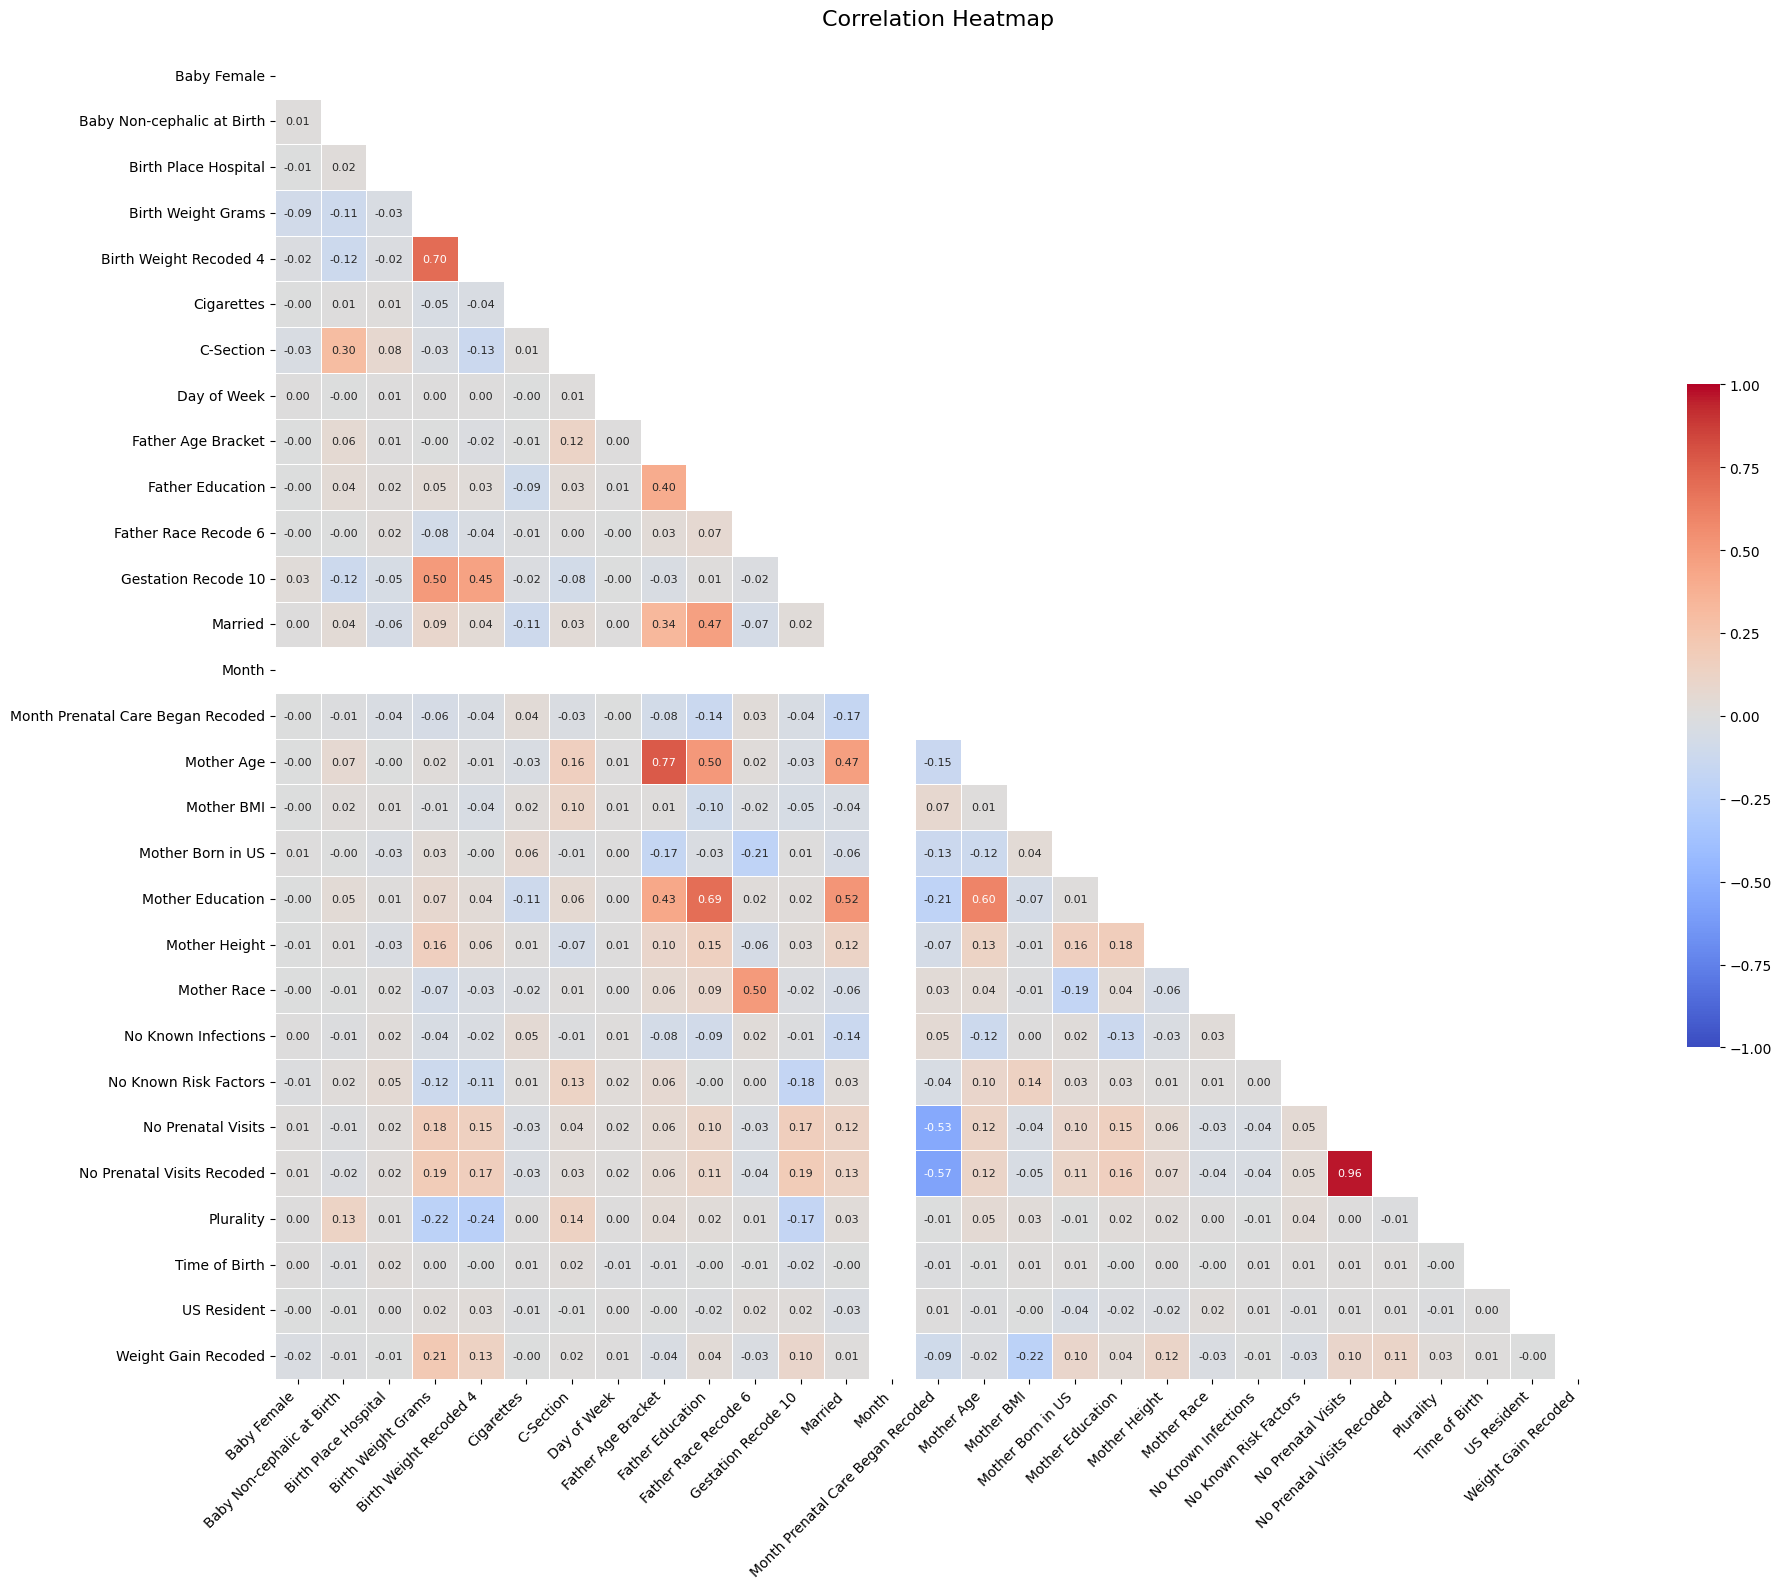

In [ ]:
# Based on above, two feutures are highly correlated
# No Prenatal Visits Recoded highly correlated with No Prenatal Visits and No Prenatal Visits Recoded (highly correlated with No Prenatal Visits)
# Create correlation matrix for numeric columns
import seaborn as sns
import matplotlib.pyplot as plt
# Create correlation matrix
correlation_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(20, 16))

# Create a mask for the upper triangle to avoid redundancy
mask = np.triu(np.ones_like(correlation_matrix))

# Create heatmap with improved readability, asked chatGPT for help with this heatmap
sns.heatmap(correlation_matrix,
            mask=mask,
            cmap='coolwarm',
            center=0,
            annot=True,  # Show numbers
            fmt='.2f',   # Round to 2 decimal places
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5},
            annot_kws={"size": 8},  # Adjust annotation size
            vmin=-1, vmax=1)        # Set correlation range

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.yticks(rotation=0)
plt.title('Correlation Heatmap', pad=20, size=16)
plt.tight_layout()
plt.show()


In [ ]:
# No Prenatal Visits Recoded highly correlated with No Prenatal Visits and No Prenatal Visits Recoded (highly correlated with No Prenatal Visits)
# Let's drop them in our pipeline.
'''
Reasons:
The original "No Prenatal Visits" contains more granular information
Having the actual number of visits provides more detail than the recoded version
We can always recode the raw numbers later if needed
The assignment mentions handling "highly correlated fields" and typically we keep the more detailed variable '''


'\nReasons:\nThe original "No Prenatal Visits" contains more granular information\nHaving the actual number of visits provides more detail than the recoded version\nWe can always recode the raw numbers later if needed\nThe assignment mentions handling "highly correlated fields" and typically we keep the more detailed variable '

In [ ]:
# Display the missing values to later handle in the pipeline:
missing_vals = df.isnull().sum()
print(missing_vals)

Baby Female                              0
Baby Non-cephalic at Birth             114
Birth Place Hospital                     2
Birth Weight Grams                      44
Birth Weight Recoded 4                  44
Cigarettes                             284
C-Section                               32
Day of Week                              0
Father Age Bracket                   10014
Father Education                     12053
Father Race Recode 6                 16250
Gestation Recode 10                     37
Married                              12355
Month                                    0
Month Prenatal Care Began Recoded     1762
Mother Age                               0
Mother BMI                               0
Mother Born in US                      185
Mother Education                      1492
Mother Height                          357
Mother Race                              0
No Known Infections                      0
No Known Risk Factors                    0
No Prenatal

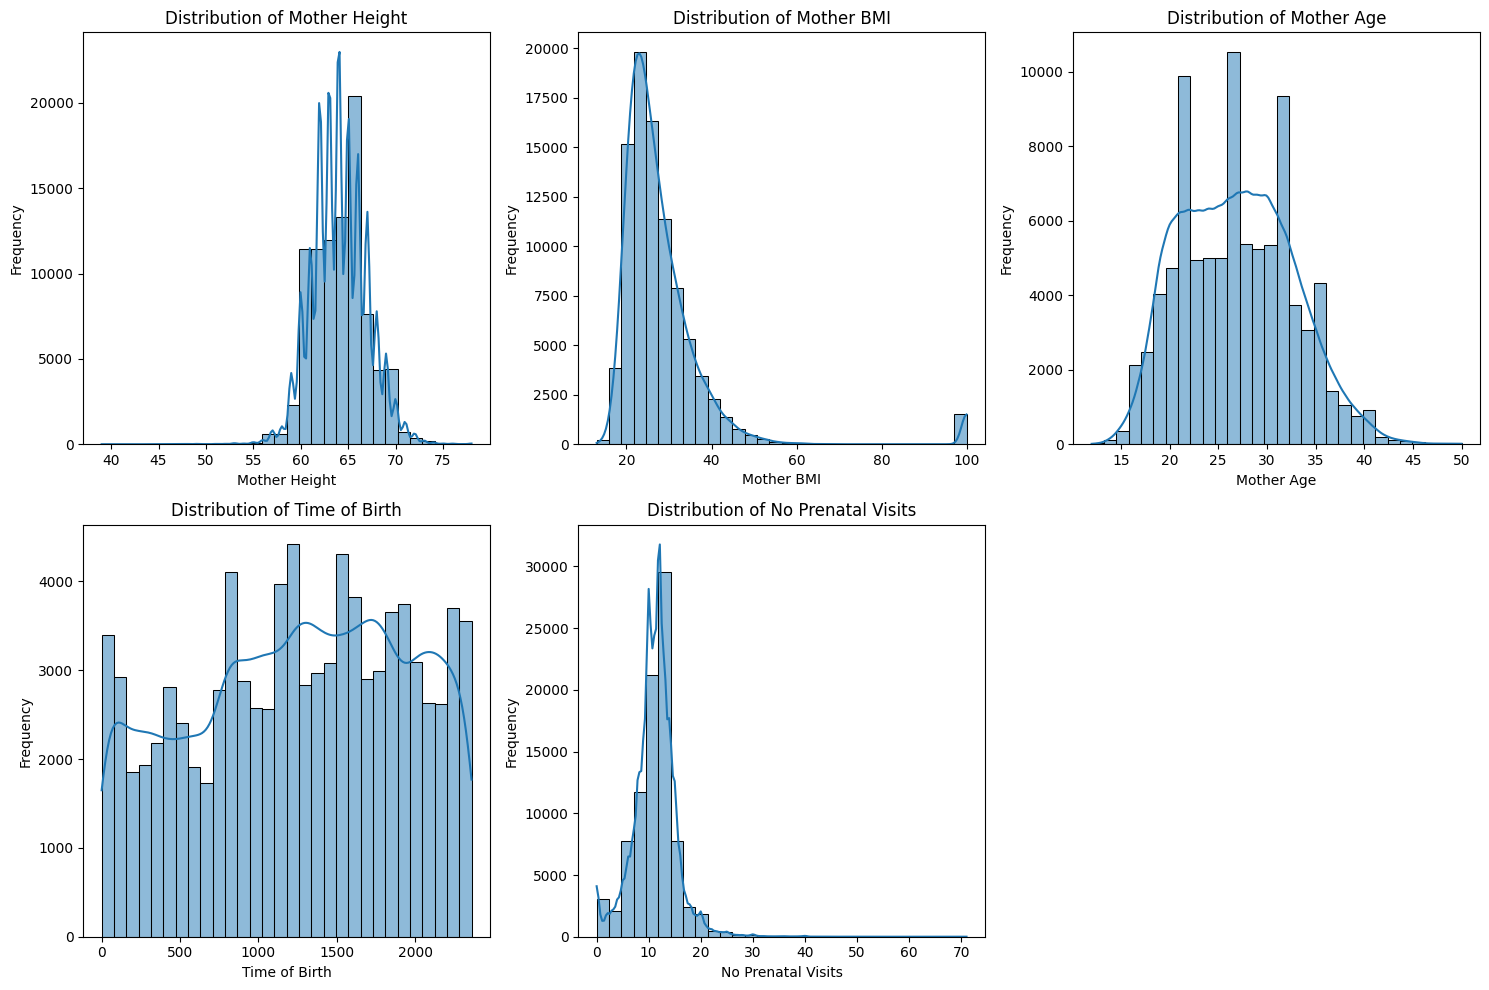

In [ ]:
num_attribs = ['Mother Height',
    'Mother BMI',
    'Mother Age',
    'Time of Birth',
    'No Prenatal Visits']

plt.figure(figsize=(15, 10))
for i, col in enumerate(num_attribs):
    plt.subplot(2, 3, i + 1)  # 2 rows, 3 columns layout
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

Birth Weight Statistics by Mother Race:
               count         mean         std    min      25%     50%  \
Mother Race                                                             
1            68260.0  3247.787006  560.075619  228.0  2965.00  3288.0   
2            12067.0  3043.219027  621.732437  227.0  2765.00  3105.0   
3              737.0  3220.616011  584.444432  301.0  2948.00  3260.0   
4             6213.0  3091.754225  545.952517  249.0  2810.00  3125.0   
5              270.0  3130.903704  557.168631  788.0  2860.75  3152.5   
6             2772.0  3195.888167  577.733329  228.0  2906.50  3240.0   

                 75%     max  
Mother Race                   
1            3600.00  6300.0  
2            3430.00  5358.0  
3            3560.00  4600.0  
4            3430.00  5340.0  
5            3513.75  4570.0  
6            3547.00  5500.0  


<ipython-input-15-1744c43194f2>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Age_Group'] = pd.cut(df['Mother Age'],
<ipython-input-15-1744c43194f2>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BMI_Category'] = pd.cut(df['Mother BMI'],


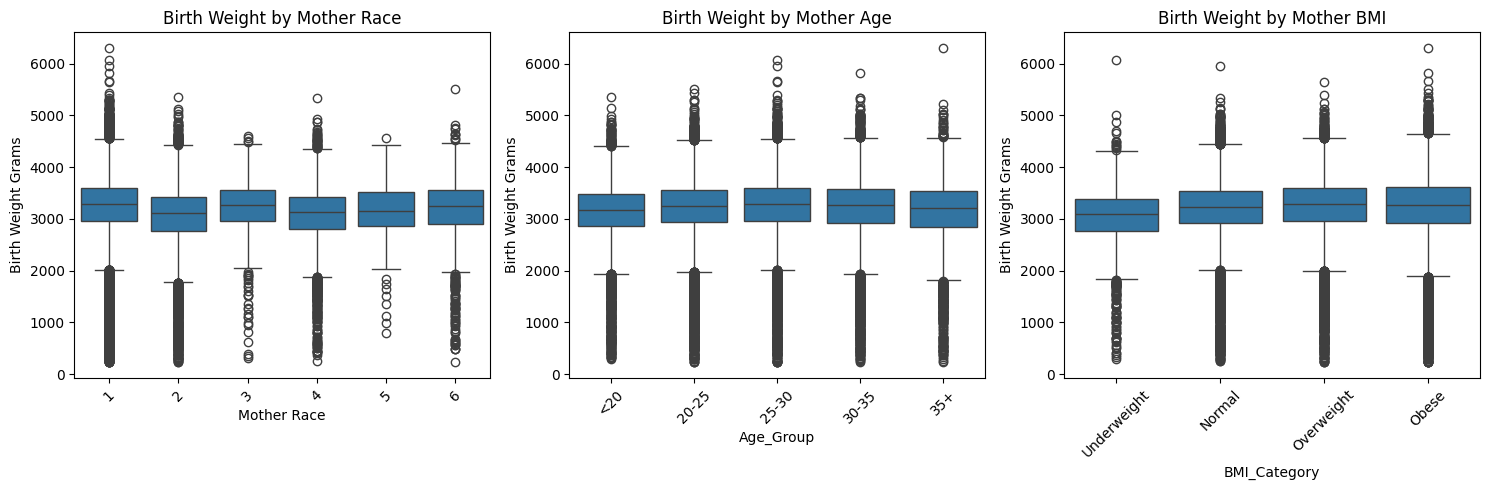


ANOVA Tests:
Mother Race: F_onewayResult(statistic=nan, pvalue=nan)
Mother Age Groups: F_onewayResult(statistic=nan, pvalue=nan)
BMI Categories: F_onewayResult(statistic=nan, pvalue=nan)


<ipython-input-15-1744c43194f2>:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in df.groupby('Age_Group')]))
<ipython-input-15-1744c43194f2>:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in df.groupby('BMI_Category')]))


In [ ]:
# Decide if we need stratification (used chatGPT for help)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('default')

# Birth Weight by Mother Race
print("Birth Weight Statistics by Mother Race:")
race_stats = df.groupby('Mother Race')['Birth Weight Grams'].describe()
print(race_stats)

# Visualization
plt.figure(figsize=(15, 5))

# 1. Birth Weight Distribution by Mother Race
plt.subplot(1, 3, 1)
sns.boxplot(data=df, x='Mother Race', y='Birth Weight Grams')
plt.title('Birth Weight by Mother Race')
plt.xticks(rotation=45)

# 2. Birth Weight Distribution by Mother Age Groups
plt.subplot(1, 3, 2)
# Create age groups
df['Age_Group'] = pd.cut(df['Mother Age'],
                        bins=[0, 20, 25, 30, 35, 100],
                        labels=['<20', '20-25', '25-30', '30-35', '35+'])
sns.boxplot(data=df, x='Age_Group', y='Birth Weight Grams')
plt.title('Birth Weight by Mother Age')
plt.xticks(rotation=45)

# 3. Birth Weight Distribution by Mother BMI Categories
plt.subplot(1, 3, 3)
# Create BMI categories
df['BMI_Category'] = pd.cut(df['Mother BMI'],
                           bins=[0, 18.5, 25, 30, 100],
                           labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
sns.boxplot(data=df, x='BMI_Category', y='Birth Weight Grams')
plt.title('Birth Weight by Mother BMI')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Statistical tests
from scipy import stats

print("\nANOVA Tests:")
print("Mother Race:", stats.f_oneway(*[group['Birth Weight Grams'].values
                                     for name, group in df.groupby('Mother Race')]))
print("Mother Age Groups:", stats.f_oneway(*[group['Birth Weight Grams'].values
                                           for name, group in df.groupby('Age_Group')]))
print("BMI Categories:", stats.f_oneway(*[group['Birth Weight Grams'].values
                                        for name, group in df.groupby('BMI_Category')]))

The differences in birth weights across races, while present, are not extreme (all means are within about 200g of each other).
It seems that there is no need for stratification.
We still need to scale because:
Mother Height is in inches (around 60-70)
Mother Age is in years (around 20-40)
Mother BMI has different range
Time of Birth is in minutes (0-2359)

In [ ]:
# Lastly, I want to bin time of the birth based on: Morning, Afternoon, Night.
'''
Morning: 5:00 AM – 11:59 AM
Afternoon: 12:00 PM – 5:59 PM
Night: 6:00 PM – 4:59 AM (including late-night and early-morning hours)
'''

df["Time_of_Birth_Category"] = pd.cut(
    df["Time of Birth"],
    bins=[0, 500, 1200, 1800, 2400],
    labels=["Early Morning", "Morning", "Afternoon", "Night"],
    right=False
)

# Check  distribution
print(df["Time_of_Birth_Category"].value_counts())

Time_of_Birth_Category
Afternoon        26685
Morning          24932
Night            23637
Early Morning    15107
Name: count, dtype: int64


<ipython-input-16-b5077b77f2f7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Time_of_Birth_Category"] = pd.cut(


In [ ]:
df[['Birth Weight Grams', 'Birth Weight Recoded 4']].tail()
df.columns

Index(['Baby Female', 'Baby Non-cephalic at Birth', 'Birth Place Hospital',
       'Birth Weight Grams', 'Birth Weight Recoded 4', 'Cigarettes',
       'C-Section', 'Day of Week', 'Father Age Bracket', 'Father Education',
       'Father Race Recode 6', 'Gestation Recode 10', 'Married', 'Month',
       'Month Prenatal Care Began Recoded', 'Mother Age', 'Mother BMI',
       'Mother Born in US', 'Mother Education', 'Mother Height', 'Mother Race',
       'No Known Infections', 'No Known Risk Factors', 'No Prenatal Visits',
       'No Prenatal Visits Recoded', 'Plurality', 'Time of Birth',
       'US Resident', 'Weight Gain Recoded', 'Age_Group', 'BMI_Category',
       'Time_of_Birth_Category'],
      dtype='object')

## <font color=green >Create the Training and Test Datasets and feed it to our pipleine




In [ ]:
# I realized that there are some missing values in y_train after I built the test spilt and pipeline.
# I am gonna imputate using mean to handle those missing values before feeding them to train test split.
imputer = SimpleImputer(strategy='mean')
# Fit the imputer on the 'Birth Weight Grams' column and transform it:
df['Birth Weight Grams'] = imputer.fit_transform(df[['Birth Weight Grams']])

<ipython-input-18-184850a08daf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Birth Weight Grams'] = imputer.fit_transform(df[['Birth Weight Grams']])


In [ ]:
# Already Dropped No Prenatal Visits Recoded
X_train_pre, X_test_pre, y_train, y_test = train_test_split(
    df.drop(columns=['Birth Weight Grams' , 'Birth Weight Recoded 4']),
    df['Birth Weight Grams'],
    test_size=.2,
    random_state=42,

)

### Prepare Data using a Pipeline

In [ ]:
cat_attribs = [
    'Baby Female', 'Baby Non-cephalic at Birth', 'Birth Place Hospital',
    'Cigarettes', 'C-Section', 'Day of Week', 'Father Race Recode 6',
    'Married', 'Month', 'Mother Born in US', 'Mother Race',
    'No Known Infections', 'No Known Risk Factors', 'Plurality',
    'US Resident']

ord_attribs = [
    'Father Education',
    'Mother Education',
    'Gestation Recode 10',
    #'Weight Gain Recoded',
   # 'Birth Weight Recoded 4',
    'Month Prenatal Care Began Recoded',
    'Father Age Bracket'
]

#set the numerical attributes
num_attribs = ['Mother Height',
    'Mother BMI',
    'Mother Age',
    'Time of Birth',
    'No Prenatal Visits']

#define pipeline for numeric attributes (this code is just a definition)
#each numeric attribute will be imputated using the Median strategy
#each numeric attribute will be scaled
num_pipeline = Pipeline( [
    ('imputer', SimpleImputer(strategy="mean")), #why mean? not median?
    ('std_scaler', StandardScaler()),
] )

cat_pipeline = Pipeline( [
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore')),
] )

ord_pipeline = Pipeline( [
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('ord', OrdinalEncoder()),
] )

#define the pipeline process for the data set
col_pipeline = ColumnTransformer( [
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs),      #because no categorical attributes, not used
    ('ord', ord_pipeline, ord_attribs)
])

#build a top-level pipeline that in the future will allow for more sophisicated data preparation steps including other ML models
full_pipeline=Pipeline([
    ('col_pipeline', col_pipeline),
    #('poly', PolynomialFeatures(degree=2) ) #OPPORTUNITY TO USE POLYNOMIAL FEATURES
])
full_pipeline

Pipeline(steps=[('col_pipeline',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['Mother Height',
                                                   'Mother BMI', 'Mother Age',
                                                   'Time of Birth',
                                                   'No Prenatal Visits']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 spa...
                                                   'Father Race Recode 6',
                                                   'Married', 'Month',
                                                   'Mother Born in US',
                                                   'Mother Race',
                                                   'No Known Infections',
                                                   'No Known Risk Factors',
                                                   'Plurality',
                                                   'US Resident']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder())]),
                                                  ['Father Education',
                                                   'Mother Education',
                                                   'Gestation Recode 10',
                                                   'Month Prenatal Care Began '
                                                   'Recoded',
                                                   'Father Age Bracket'])]))])

### Fit and transform

In [ ]:
df.head()

,Baby Female,Baby Non-cephalic at Birth,Birth Place Hospital,Birth Weight Grams,Birth Weight Recoded 4,Cigarettes,C-Section,Day of Week,Father Age Bracket,Father Education,...,No Known Risk Factors,No Prenatal Visits,No Prenatal Visits Recoded,Plurality,Time of Birth,US Resident,Weight Gain Recoded,Age_Group,BMI_Category,Time_of_Birth_Category
1679,1,0.0,1.0,3605.0,3.0,0.0,0.0,1,5.0,8.0,...,0,10.0,6.0,1,145.0,1.0,4.0,30-35,Overweight,Early Morning
1681,0,0.0,1.0,3487.0,3.0,0.0,0.0,5,5.0,7.0,...,1,3.0,3.0,1,2056.0,1.0,3.0,30-35,Normal,Night
1682,0,0.0,1.0,2940.0,3.0,0.0,0.0,6,4.0,3.0,...,2,11.0,7.0,1,425.0,1.0,4.0,25-30,Overweight,Early Morning
1683,1,0.0,1.0,3170.0,3.0,0.0,0.0,1,3.0,3.0,...,0,9.0,6.0,1,613.0,1.0,5.0,<20,Overweight,Morning
1686,1,0.0,1.0,4455.0,3.0,0.0,1.0,5,7.0,7.0,...,0,17.0,10.0,1,1051.0,1.0,NaN,30-35,Overweight,Morning


In [ ]:
pipeline = full_pipeline  # Create an instance
pipeline.fit(X_train_pre, y_train)
X_train = pipeline.transform(X_train_pre)
X_test = pipeline.transform(X_test_pre)

In [ ]:
print(X_train.shape)


(72290, 58)


### Create a list of Model Features (i.e. attributes)

In [ ]:
#create a list of attributes   - THIS CODE IS NEW but able to be used more universally
attributes = full_pipeline.get_feature_names_out()
print(f"{len(attributes):,} Attributes:\n", "\n".join(attributes), sep="")

58 Attributes:
num__Mother Height
num__Mother BMI
num__Mother Age
num__Time of Birth
num__No Prenatal Visits
cat__Baby Female_0.0
cat__Baby Female_1.0
cat__Baby Non-cephalic at Birth_0.0
cat__Baby Non-cephalic at Birth_1.0
cat__Birth Place Hospital_0.0
cat__Birth Place Hospital_1.0
cat__Cigarettes_0.0
cat__Cigarettes_1.0
cat__C-Section_0.0
cat__C-Section_1.0
cat__Day of Week_1.0
cat__Day of Week_2.0
cat__Day of Week_3.0
cat__Day of Week_4.0
cat__Day of Week_5.0
cat__Day of Week_6.0
cat__Day of Week_7.0
cat__Father Race Recode 6_1.0
cat__Father Race Recode 6_2.0
cat__Father Race Recode 6_3.0
cat__Father Race Recode 6_4.0
cat__Father Race Recode 6_5.0
cat__Father Race Recode 6_6.0
cat__Married_0.0
cat__Married_1.0
cat__Month_9.0
cat__Mother Born in US_0.0
cat__Mother Born in US_1.0
cat__Mother Race_1.0
cat__Mother Race_2.0
cat__Mother Race_3.0
cat__Mother Race_4.0
cat__Mother Race_5.0
cat__Mother Race_6.0
cat__No Known Infections_0.0
cat__No Known Infections_1.0
cat__No Known Infections_

### Determine a Baseline

In [ ]:

X_train.shape

(72290, 58)

In [ ]:
#calculate the average infant weight
baseline_prediction = y_train.mean()

#populate an array with the baseline prediction value
predictions = np.full(shape=y_train.shape[0], fill_value = baseline_prediction)

#determine the Root Mean Squared Error based on the actual vs. the baseline prediction
baseline_rmse = root_mean_squared_error(y_train, predictions)
print(f"Baseline guess is: {baseline_prediction:,.0f}")
print(f"Baseline Performance (of this guess): RMSE {baseline_rmse:,.0f}")

Baseline guess is: 3,208
Baseline Performance (of this guess): RMSE 574


### Train and Evaluate the models

In [ ]:
modelList = [LinearRegression(),
             Ridge(random_state=42),
             Lasso(random_state=42),
             ElasticNet(random_state=42),
             SGDRegressor(random_state=42),              # needs at least 10K rows
             DecisionTreeRegressor(random_state=42),
             RandomForestRegressor(random_state=42),     # most time consuming so may want to skip
             GradientBoostingRegressor(random_state=42), # also one of the most time consuming algorithms
             HistGradientBoostingRegressor(random_state=42),
             KNeighborsRegressor()
            ]

for model in modelList:

    #time how long a model needs "roughly" to learn
    print("-"*25)
    print(model)
    start_time = time.time()

    #fit the model to the prepared test data
    model.fit(X_train,y_train)

    #see how well the model fits
    #calculate the predicted values
    predictions = model.predict(X_train)

    #compare the predicted to the actuals
    rmse = root_mean_squared_error(y_train, predictions)
    print(f" Training Error (RMSE): {rmse:,.0f}")

    #use cross valudation to process the data 5 different ways
    scores = cross_val_score(model, X_train, y_train,
                         scoring="neg_root_mean_squared_error", cv=5)

    #calculate the average score over the 10 different cross validations
    print(f"Average CV Error (RMSE): {-scores.mean():,.0f}")
    print(f"Standard deviation: {scores.std():,.0f}" )

    print(f"---> {time.time() - start_time:,.2f} seconds")

-------------------------
LinearRegression()
 Training Error (RMSE): 472
Average CV Error (RMSE): 472
Standard deviation: 3
---> 1.74 seconds
-------------------------
Ridge(random_state=42)
 Training Error (RMSE): 472
Average CV Error (RMSE): 472
Standard deviation: 3
---> 0.44 seconds
-------------------------
Lasso(random_state=42)
 Training Error (RMSE): 472
Average CV Error (RMSE): 472
Standard deviation: 3
---> 1.04 seconds
-------------------------
ElasticNet(random_state=42)
 Training Error (RMSE): 486
Average CV Error (RMSE): 486
Standard deviation: 4
---> 0.93 seconds
-------------------------
SGDRegressor(random_state=42)
 Training Error (RMSE): 503
Average CV Error (RMSE): 475
Standard deviation: 4
---> 7.10 seconds
-------------------------
DecisionTreeRegressor(random_state=42)
 Training Error (RMSE): 1
Average CV Error (RMSE): 620
Standard deviation: 5
---> 7.84 seconds
-------------------------
RandomForestRegressor(random_state=42)
 Training Error (RMSE): 164
Average C

### Tuning the best model using grid search

<font color=red>THIS MAY TAKE TIME

In [ ]:
# create a new HistGradientBoostingRegressor because it had the best performance
model = HistGradientBoostingRegressor( random_state=42 )

#create a parameter grid that determines the variable hyperparameters
param_grid = [
    {'learning_rate': [.1, .05, .01],
     'max_iter': [100, 200 ],         #will add to processing time if allowing for more than normal iterations
     'l2_regularization': [0,1,2]
    }
]

# train across 5 folds
grid_search = GridSearchCV(model, param_grid, cv=5,
                           scoring='neg_root_mean_squared_error',
                           return_train_score=True)

#fit the model to the data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=HistGradientBoostingRegressor(random_state=42),
             param_grid=[{'l2_regularization': [0, 1, 2],
                          'learning_rate': [0.1, 0.05, 0.01],
                          'max_iter': [100, 200]}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [ ]:
#let's look at the score of each hyperparameter combination tested during the grid search
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(f'{-mean_score:15,.2f} - {params}')

         427.37 - {'l2_regularization': 0, 'learning_rate': 0.1, 'max_iter': 100}
         427.38 - {'l2_regularization': 0, 'learning_rate': 0.1, 'max_iter': 200}
         428.02 - {'l2_regularization': 0, 'learning_rate': 0.05, 'max_iter': 100}
         427.28 - {'l2_regularization': 0, 'learning_rate': 0.05, 'max_iter': 200}
         459.97 - {'l2_regularization': 0, 'learning_rate': 0.01, 'max_iter': 100}
         437.49 - {'l2_regularization': 0, 'learning_rate': 0.01, 'max_iter': 200}
         427.50 - {'l2_regularization': 1, 'learning_rate': 0.1, 'max_iter': 100}
         427.54 - {'l2_regularization': 1, 'learning_rate': 0.1, 'max_iter': 200}
         428.11 - {'l2_regularization': 1, 'learning_rate': 0.05, 'max_iter': 100}
         427.37 - {'l2_regularization': 1, 'learning_rate': 0.05, 'max_iter': 200}
         460.07 - {'l2_regularization': 1, 'learning_rate': 0.01, 'max_iter': 100}
         437.52 - {'l2_regularization': 1, 'learning_rate': 0.01, 'max_iter': 200}
        

In [ ]:
#display the parameters with the best solution (lowest score)
grid_search.best_params_

{'l2_regularization': 0, 'learning_rate': 0.05, 'max_iter': 200}

In [ ]:
#display the best model and its parameters (similar to above but not in dictionary format)
grid_search.best_estimator_

HistGradientBoostingRegressor(l2_regularization=0, learning_rate=0.05,
                              max_iter=200, random_state=42)

### Confirm that Tuning Produces a Better Result

In [ ]:
#taking the best model so far and making it our final model
model = grid_search.best_estimator_
scores = cross_val_score(model, X_train, y_train,
                         scoring="neg_root_mean_squared_error", cv=5)

# look at the results of each fold
scores

array([-423.87584852, -429.25820743, -431.53944217, -428.37102272,
       -423.33255468])

In [ ]:
print(f"Average of RMSE across folds: {-scores.mean():,.0f}")
print(f"Standard deviation: {scores.std():,.0f}" )

Average of RMSE across folds: 427
Standard deviation: 3


### Review Learning Curve

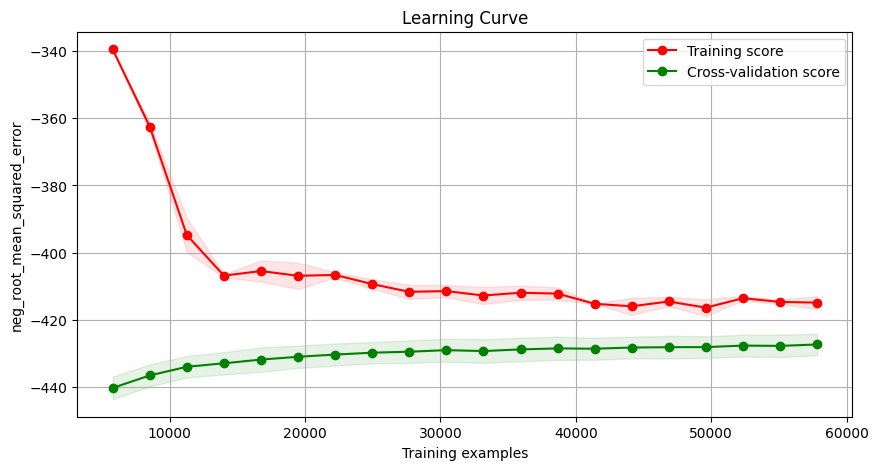

In [ ]:
plot_learning_curve(model, X_train, y_train)

### Evaluate on the Test Set

In [ ]:
#predict the test data set
predictions = model.predict(X_test)

#measure performance
rmse = root_mean_squared_error(y_test, predictions)
print(f"TEST Predition Error (RMSE): {rmse:,.0f}")

TEST Predition Error (RMSE): 422


In [ ]:
#We can compute a 95% confidence interval for the test RMSE
confidence = 0.95
squared_errors = (predictions - y_test) ** 2
confidence_interval = np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                                               loc=squared_errors.mean(), scale=stats.sem(squared_errors)))
print( f"{confidence*100:.0f}% Confidence Intervals: {confidence_interval[0]:,.2f} -- {confidence_interval[1]:,.2f}" )

95% Confidence Intervals: 416.78 -- 427.70


### Predict

In [ ]:
sampledf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Baby Female                        5 non-null      int64  
 1   Baby Non-cephalic at Birth         5 non-null      int64  
 2   Birth Place Hospital               5 non-null      int64  
 3   Cigarettes                         5 non-null      int64  
 4   C-Section                          5 non-null      int64  
 5   Day of Week                        5 non-null      int64  
 6   Father Age Bracket                 4 non-null      float64
 7   Father Education                   3 non-null      float64
 8   Father Race Recode 6               3 non-null      float64
 9   Gestation Recode 10                5 non-null      int64  
 10  Married                            5 non-null      int64  
 11  Month                              5 non-null      int64  
 12

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90363 entries, 1679 to 1042157
Data columns (total 32 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   Baby Female                        90363 non-null  int64   
 1   Baby Non-cephalic at Birth         90249 non-null  float64 
 2   Birth Place Hospital               90361 non-null  float64 
 3   Birth Weight Grams                 90363 non-null  float64 
 4   Birth Weight Recoded 4             90319 non-null  float64 
 5   Cigarettes                         90079 non-null  float64 
 6   C-Section                          90331 non-null  float64 
 7   Day of Week                        90363 non-null  int64   
 8   Father Age Bracket                 80349 non-null  float64 
 9   Father Education                   78310 non-null  float64 
 10  Father Race Recode 6               74113 non-null  float64 
 11  Gestation Recode 10                90326 

#### Transforming the Test df

In [ ]:
# Create an instance
X_predict = pipeline.transform(sampledf)

In [ ]:
X_predict.shape

(5, 58)

In [ ]:
weight_prediction = model.predict(X_predict)

In [ ]:
sampledf['Birth Weight Prediction HSGB'] = weight_prediction

In [ ]:
sampledf.head()

,Baby Female,Baby Non-cephalic at Birth,Birth Place Hospital,Cigarettes,C-Section,Day of Week,Father Age Bracket,Father Education,Father Race Recode 6,Gestation Recode 10,...,Mother Race,No Known Infections,No Known Risk Factors,No Prenatal Visits,No Prenatal Visits Recoded,Plurality,Time of Birth,US Resident,Weight Gain Recoded,Birth Weight Prediction HSGB
0,1,0,0,0,0,7,7.0,5.0,1.0,10,...,1,0,0,10,6,1,1218,1,NaN,3614.735739
1,1,0,1,0,0,2,2.0,2.0,1.0,8,...,1,0,0,13,8,1,1122,1,1.0,3340.103693
2,0,0,1,0,1,3,6.0,6.0,4.0,5,...,1,0,0,4,3,1,1954,1,4.0,2521.648541
3,1,0,1,0,0,3,NaN,NaN,NaN,7,...,1,0,1,3,3,1,1236,1,5.0,3206.758602
4,1,0,1,0,0,7,6.0,NaN,NaN,8,...,1,0,0,9,6,1,1007,1,3.0,3224.701406


## Re-run the model with a linear algorithm like Ridge

In [ ]:
model_ridge = Ridge(random_state=42)

# create a parameter grid that determines the variable hyperparameters for Ridge
param_grid_ridge = [
    {'alpha': [0.01, 0.1, 1, 10, 100]}
]

# train across 5 folds using negative RMSE as the scoring metric
grid_search_ridge = GridSearchCV(model_ridge, param_grid_ridge, cv=5,
                           scoring='neg_root_mean_squared_error',
                           return_train_score=True)

# fit the model to the data using grid_search_ridge instead of grid_search
grid_search_ridge.fit(X_train, y_train) # Changed from grid_search to grid_search_ridge

# Print the best parameters and corresponding score.
print("Best Ridge Parameters:", grid_search_ridge.best_params_)
print("Best CV RMSE:", -grid_search_ridge.best_score_) # Changed from grid_search to grid_search_ridge

Best Ridge Parameters: {'alpha': 10}
Best CV RMSE: 472.01417839922505


In [ ]:
cvres = grid_search_ridge.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(f'{-mean_score:15,.2f} - {params}')

         472.02 - {'alpha': 0.01}
         472.02 - {'alpha': 0.1}
         472.02 - {'alpha': 1}
         472.01 - {'alpha': 10}
         472.11 - {'alpha': 100}


In [ ]:
print("Best Ridge Parameters:", grid_search_ridge.best_params_)

Best Ridge Parameters: {'alpha': 10}


In [ ]:
best_model = grid_search_ridge.best_estimator_
print("Best Ridge Model:")
print(best_model)

Best Ridge Model:
Ridge(alpha=10, random_state=42)


In [ ]:
# Taking the best Ridge model from grid search as our final model
ridge_model = grid_search_ridge.best_estimator_

# Evaluate the best Ridge model using 5-fold cross-validation
scores = cross_val_score(ridge_model, X_train, y_train,
                         scoring="neg_root_mean_squared_error", cv=5)

# Display the cross-validation RMSE scores (converted to positive values)
print("Cross-validation RMSE scores for the best Ridge model:")
print([-score for score in scores])


Cross-validation RMSE scores for the best Ridge model:
[467.04171758321826, 473.31818669171764, 475.75549888205427, 473.9655994530025, 469.9898893861326]


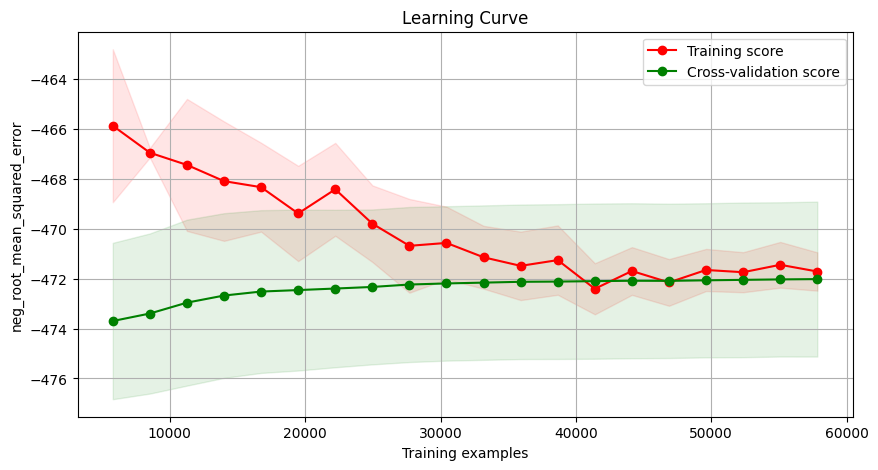

In [ ]:
plot_learning_curve(ridge_model, X_train, y_train)

In [ ]:
# Predict the test data set using the best Ridge model
predictions = ridge_model.predict(X_test)

# Measure performance using RMSE
rmse = root_mean_squared_error(y_test, predictions)
print(f"TEST Prediction Error (RMSE): {rmse:,.0f}")

TEST Prediction Error (RMSE): 467


In [ ]:
# We can compute a 95% confidence interval for the test RMSE using the Ridge model predictions
confidence = 0.95
squared_errors = (predictions - y_test) ** 2
confidence_interval = np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                                               loc=squared_errors.mean(), scale=stats.sem(squared_errors)))
print(f"{confidence*100:.0f}% Confidence Interval for RMSE: {confidence_interval[0]:,.2f} -- {confidence_interval[1]:,.2f}")


95% Confidence Interval for RMSE: 461.33 -- 473.45


### Predict using ridge

In [ ]:
# Fit the Ridge model (model_ridge) to the training data
model_ridge.fit(X_train, y_train)



# Now predict using the fitted Ridge model
weight_prediction_ridge = model_ridge.predict(X_predict)

# Add the predicted weights to the original DataFrame
sampledf['Birth Weight Prediction Ridge'] = weight_prediction_ridge

In [ ]:
sampledf[['Birth Weight Prediction Ridge', 'Birth Weight Prediction HSGB']]

,Birth Weight Prediction Ridge,Birth Weight Prediction HSGB
0,3825.202795,3614.735739
1,3384.246326,3340.103693
2,2855.867455,2521.648541
3,2992.827607,3206.758602
4,3240.909572,3224.701406
